In [1]:
import glob
import random
import math
import re

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import nltk
from nltk import word_tokenize
from nltk import FreqDist
from nltk import regexp_tokenize
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def read_texts(path):
    pattern = r'''(?x)     # set flag to allow verbose regexps
        (?:[A-Z]\.)+       # abbreviations, e.g. U.S.A.
        | \w+(?:-\w+)*       # words with optional internal hyphens
        | \$?\d+(?:\.\d+)?%? # currency and percentages, e.g. $12.40, 82%
        | \.\.\.             # ellipsis
        | [][.,;"'?():-_`]   # these are separate tokens; includes ], [
    '''
    res = []
    for fnm in glob.glob(path):
        if fnm.endswith('txt'):
            with open(fnm, 'r', encoding='utf-8') as f:
                raw = f.read()
                raw = raw.replace('<br />', '')
                res.append(regexp_tokenize(raw, pattern))
    return res

train_neg = read_texts('aclImdb_v1/aclImdb/train/neg/*')
train_pos = read_texts('aclImdb_v1/aclImdb/train/pos/*')
test_neg = read_texts('aclImdb_v1/aclImdb/test/neg/*')
test_pos = read_texts('aclImdb_v1/aclImdb/test/pos/*')

In [157]:
train_pos[3][:10]

['This', 'is', 'not', 'the', 'typical', 'Mel', 'Brooks', 'film', '.', 'It']

In [3]:
#split train_val
random.seed(340239432)

def train_val(samples, train_prop):
    n_train = math.floor(len(samples)*train_prop)
    assignments = [1]*n_train + [0]*(len(samples)-n_train)
    random.shuffle(assignments)
    return ([smp for smp, asn in zip(samples, assignments) if asn],
            [smp for smp, asn in zip(samples, assignments) if not asn])

train_neg, val_neg = train_val(train_neg, 0.7)
train_pos, val_pos = train_val(train_pos, 0.7)

In [4]:
# Lengths of texts
lens = pd.Series([len(t) for t in train_pos+train_neg])
lens.describe(percentiles = [.01, .05, .25, .5, .75, .95, .99])
# Lengths range from ~10 to ~2000 words

count    17500.000000
mean       272.805314
std        203.232909
min         11.000000
1%          49.000000
5%          75.000000
25%        147.000000
50%        203.000000
75%        331.000000
95%        698.000000
99%       1065.030000
max       2735.000000
dtype: float64

In [5]:
################################################
####### Analyze positive and negative vocabulary
################################################

In [6]:
def words(texts):
    return FreqDist([w.lower() for t in texts for w in t if re.match(r'\w+', w)])
word_freq_pos = words(train_pos)
word_freq_neg = words(train_neg)
word_freqs_by_label = pd.DataFrame([(w,word_freq_pos[w]) for w in word_freq_pos]).merge(
    pd.DataFrame([(w,word_freq_neg[w]) for w in word_freq_neg]),
    on = 0,
    how = 'outer'
).set_index(0)
word_freqs_by_label.columns = ('pos', 'neg')
word_freqs_by_label = word_freqs_by_label.fillna(0)
word_freqs_by_label.pos = 1000*word_freqs_by_label.pos/sum(word_freqs_by_label.pos)
word_freqs_by_label.neg = 1000*word_freqs_by_label.neg/sum(word_freqs_by_label.neg)
word_freqs_by_label['avg'] = (word_freqs_by_label.pos + word_freqs_by_label.neg) / 2
word_freqs_by_label['lsr'] =  np.log(((word_freqs_by_label.pos + min(word_freqs_by_label[word_freqs_by_label.pos > 0].pos)) /
                              (word_freqs_by_label.neg + min(word_freqs_by_label[word_freqs_by_label.neg > 0].neg))))

In [162]:
x = word_freqs_by_label[
    (word_freqs_by_label.avg > 0.1)
].sort_values('lsr', ascending=False)[['avg', 'lsr']].head(10)
x.columns=['freq per 1000', 'polarity']
x.index.rename('', inplace=True)
x

,freq per 1000,polarity
,,
superb,0.114011,1.647792
wonderful,0.281337,1.635546
fantastic,0.131044,1.483666
excellent,0.358553,1.404641
amazing,0.220074,1.382232
powerful,0.101954,1.233854
perfect,0.258036,1.195234
brilliant,0.197719,1.190903
perfectly,0.106520,1.185501


In [163]:
x = word_freqs_by_label[
    (word_freqs_by_label.avg > 0.1)
].sort_values('lsr')[['avg', 'lsr']].head(10)
x.columns=['freq per 1000', 'polarity']
x.index.rename('', inplace=True)
x

,freq per 1000,polarity
,,
waste,0.245989,-2.654203
awful,0.286881,-2.309140
poorly,0.112862,-2.308945
worst,0.463288,-2.259617
horrible,0.197186,-1.953760
lame,0.117384,-1.924649
crap,0.168255,-1.782318
worse,0.244137,-1.781294
badly,0.114908,-1.745160


In [9]:
#Allow words that are common or a weighted combination of common and highly polar

word_freqs_by_label['scr'] = word_freqs_by_label.avg * (0.5+np.abs(word_freqs_by_label.lsr))

# too rare words contain a lot of proper names and likely movie-specific references
word_freqs_by_label[
    word_freqs_by_label['scr'] > 0.05
].sort_values('avg')[:10]

# Setting the cutoff so that the rarest words contain some obviously relevant ones 
word_freqs_by_label[
     word_freqs_by_label['scr'] > 0.1
].sort_values('avg')[:10]

,pos,neg,avg,lsr,scr
0,,,,,
boll,0.000000,0.046686,0.023343,-4.595122,0.118936
seagal,0.000953,0.058844,0.029899,-3.725820,0.126346
lousy,0.006194,0.065653,0.035923,-2.294009,0.100370
blah,0.005718,0.069057,0.037387,-2.418307,0.109108
delightful,0.078621,0.009726,0.044173,2.047054,0.112512
sucks,0.012389,0.077324,0.044856,-1.799748,0.103158
unfunny,0.006671,0.083646,0.045159,-2.465653,0.133924
friendship,0.079097,0.013131,0.046114,1.765378,0.104465
vampires,0.013818,0.078783,0.046301,-1.712964,0.102462


In [10]:
vocab = word_freqs_by_label[
    word_freqs_by_label['scr'] > 0.1
].copy()
known_words = set(vocab.index)

In [11]:
################################################
####### Analyze positive and negative n-grams
####### for differences from unigram-expected values
################################################

In [12]:
def grams(texts, n):
    grams = []
    for t in texts:
        w = [w.lower() if w.lower() in known_words else 'NOT_KNOWN_WORD' for w in t]
        g = nltk.ngrams(w, n)
        g = [gram for gram in g if not 'NOT_KNOWN_WORD' in gram]
        grams += g
    return FreqDist(grams)

def gram_freqs(n):
    gram_freq_pos = grams(train_pos,n)
    gram_freq_neg = grams(train_neg,n)
    gram_freqs_by_label = pd.DataFrame([(g,gram_freq_pos[g]) for g in gram_freq_pos]).merge(
        pd.DataFrame([(g,gram_freq_neg[g]) for g in gram_freq_neg]),
        on = 0,
        how = 'outer'
    ).set_index(0)
    gram_freqs_by_label.columns = ('pos', 'neg')
    gram_freqs_by_label = gram_freqs_by_label.fillna(0)
    gram_freqs_by_label.pos = 1000*gram_freqs_by_label.pos/sum(gram_freqs_by_label.pos)
    gram_freqs_by_label.neg = 1000*gram_freqs_by_label.neg/sum(gram_freqs_by_label.neg)
    gram_freqs_by_label['avg'] = (gram_freqs_by_label.pos + gram_freqs_by_label.neg) / 2
    for i in range(n):
        gram_freqs_by_label['word{}'.format(i)] = [k[i] for k in gram_freqs_by_label.index]
    for i in range(n):
        gram_freqs_by_label['word{}_lsr'.format(i)] = [
            word_freqs_by_label.loc[k, 'lsr'] for k in gram_freqs_by_label['word{}'.format(i)]]
        
    gram_freqs_by_label['gram_lsr'] =  np.log(((gram_freqs_by_label.pos + 
                                                min(gram_freqs_by_label[gram_freqs_by_label.pos > 0].pos)) /
                                  (gram_freqs_by_label.neg + min(gram_freqs_by_label[gram_freqs_by_label.neg > 0].neg))))
    return gram_freqs_by_label

bigram_freqs_by_label = gram_freqs(2)
trigram_freqs_by_label = gram_freqs(3)

In [13]:
# Most positive bigrams
bigram_freqs_by_label[
    (bigram_freqs_by_label.avg > 0.1)
].sort_values('gram_lsr', ascending=False).head(15)

,pos,neg,avg,word0,word1,word0_lsr,word1_lsr,gram_lsr
0,,,,,,,,
"(a, must)",0.202021,0.015305,0.108663,a,must,0.027597,0.033116,2.524415
"(is, excellent)",0.188358,0.031566,0.109962,is,excellent,0.105428,1.404641,1.761588
"(must, see)",0.182502,0.031566,0.107034,must,see,0.033116,0.066250,1.730172
"(a, wonderful)",0.286929,0.054523,0.170726,a,wonderful,0.027597,1.635546,1.646623
"(love, this)",0.185430,0.035392,0.110411,love,this,0.669023,-0.164442,1.634778
"(an, excellent)",0.337678,0.075566,0.206622,an,excellent,0.067788,1.404641,1.487389
"(may, not)",0.234227,0.060262,0.147245,may,not,0.364392,-0.147194,1.346005
"(is, great)",0.279121,0.073653,0.176387,is,great,0.105428,0.870631,1.322864
"(i, enjoyed)",0.233252,0.062175,0.147713,i,enjoyed,-0.157713,0.938172,1.311075


In [14]:
# Most negative bigrams
bigram_freqs_by_label[
    (bigram_freqs_by_label.avg > 0.1)
].sort_values('gram_lsr').head(15)

,pos,neg,avg,word0,word1,word0_lsr,word1_lsr,gram_lsr
0,,,,,,,,
"(waste, your)",0.007808,0.220003,0.113905,waste,your,-2.654203,-0.345259,-3.225102
"(worst, movie)",0.008784,0.216177,0.112480,worst,movie,-2.259617,-0.280679,-3.102274
"(waste, of)",0.022447,0.435224,0.228835,waste,of,-2.654203,0.085446,-2.924348
"(t, waste)",0.012687,0.192264,0.102476,t,waste,-0.412641,-2.654203,-2.649120
"(a, waste)",0.019519,0.229569,0.124544,a,waste,0.027597,-2.654203,-2.420184
"(bad, acting)",0.018543,0.198959,0.108751,bad,acting,-1.375540,-0.538950,-2.326511
"(the, worst)",0.124921,1.269323,0.697122,the,worst,0.032835,-2.259617,-2.311526
"(worse, than)",0.021471,0.199916,0.110693,worse,than,-1.781294,-0.109624,-2.191523
"(bad, movie)",0.026351,0.228612,0.127481,bad,movie,-1.375540,-0.280679,-2.128344


In [15]:
# Most positive trigrams
trigram_freqs_by_label[
    (trigram_freqs_by_label.avg > 0.1)
].sort_values('gram_lsr', ascending=False).head(15)

,pos,neg,avg,word0,word1,word2,word0_lsr,word1_lsr,word2_lsr,gram_lsr
0,,,,,,,,,,
"(a, must, see)",0.201263,0.015771,0.108517,a,must,see,0.027597,0.033116,0.066250,2.466737
"(a, great, job)",0.174625,0.027241,0.100933,a,great,job,0.027597,0.870631,0.602726,1.815054
"(of, the, best)",0.847968,0.137640,0.492804,of,the,best,0.085446,0.032835,0.702949,1.809581
"(may, not, be)",0.182025,0.035844,0.108934,may,not,be,0.364392,-0.147194,-0.168835,1.593848
"(is, a, great)",0.395126,0.086025,0.240576,is,a,great,0.105428,0.027597,0.870631,1.511776
"(of, the, greatest)",0.170186,0.037278,0.103732,of,the,greatest,0.085446,0.032835,1.064778,1.489416
"(i, first, saw)",0.184984,0.047314,0.116149,i,first,saw,-0.157713,0.050131,0.104352,1.341584
"(the, best, of)",0.244179,0.064519,0.154349,the,best,of,0.032835,0.702949,0.085446,1.315009
"(a, great, film)",0.167226,0.045880,0.106553,a,great,film,0.027597,0.870631,0.052063,1.271354


In [16]:
# Most negative trigrams
trigram_freqs_by_label[
    (trigram_freqs_by_label.avg > 0.1)
].sort_values('gram_lsr', ascending=True).head(15)

,pos,neg,avg,word0,word1,word2,word0_lsr,word1_lsr,word2_lsr,gram_lsr
0,,,,,,,,,,
"(the, worst, movie)",0.008879,0.255208,0.132043,the,worst,movie,0.032835,-2.259617,-0.280679,-3.209813
"(of, the, worst)",0.023678,0.577802,0.300740,of,the,worst,0.085446,0.032835,-2.259617,-3.136539
"(waste, your, time)",0.010359,0.266678,0.138518,waste,your,time,-2.654203,-0.345259,0.010447,-3.120004
"(t, waste, your)",0.008879,0.227966,0.118423,t,waste,your,-0.412641,-2.654203,-0.345259,-3.097601
"(waste, of, time)",0.016279,0.346968,0.181623,waste,of,time,-2.654203,0.085446,0.010447,-2.976492
"(this, piece, of)",0.013319,0.220798,0.117058,this,piece,of,-0.164442,-0.332395,0.085446,-2.709177
"(a, waste, of)",0.020718,0.303955,0.162337,a,waste,of,0.027597,-2.654203,0.085446,-2.621579
"(to, sit, through)",0.023678,0.193556,0.108617,to,sit,through,-0.054645,-0.688241,-0.083651,-2.047779
"(of, my, life)",0.025158,0.176351,0.100755,of,my,life,0.085446,0.048249,0.537760,-1.898247


In [17]:
##################################################
##### Linear model to identify informative grams##
##################################################
# Get the features for linear model: weaker_word, stronger_word
bigrams_for_model = bigram_freqs_by_label[bigram_freqs_by_label.avg > 0.02]
X  = np.take_along_axis(
    np.array(bigrams_for_model[['word0_lsr', 'word1_lsr']]),
    np.argsort(
    np.abs(np.array(bigrams_for_model[['word0_lsr', 'word1_lsr']])),
    axis=-1),
    1
)
#X = PolynomialFeatures(interaction_only=True).fit_transform(X)
y = bigrams_for_model['gram_lsr']

# trim outliers
for col in range(1,np.shape(X)[1]):
    vals = X[:,col]
    m = np.mean(vals)
    s = np.std(vals)
    X[:,col][((vals - m) / s) > 3] = m+3*s
    X[:,col][((vals - m) / s) < -3] = m-3*s

In [18]:
# Number of bigrams that are frequent enough to model
np.shape(X)

(7297, 2)

In [19]:
# Coefficients of bigram model
reg = linear_model.LinearRegression()
reg.fit(X,y)
reg.coef_

array([0.62512758, 1.11845014])

In [166]:
len(word_freqs_by_label)

78295

In [164]:
len(bigram_freqs_by_label)

125004

In [165]:
len(trigram_freqs_by_label)

495856

In [25]:
bigram_model = pd.DataFrame(
    {
    'gram':list(bigrams_for_model.index),
    'freq':bigrams_for_model.avg,
    'exp_polarity':reg.predict(X),
    'actual_polarity':y,
    }
).reset_index(drop=True)
bigram_model['residual'] = bigram_model['actual_polarity'] - bigram_model['exp_polarity']

In [26]:
# Unexpectedly positive bigrams
bigram_model[bigram_model['residual'] > 1].sort_values('residual', ascending=False).head(10)

,gram,exp_polarity,actual_polarity,freq,residual
889,"(well, worth)",0.571541,3.028245,0.081912,2.456704
663,"(a, must)",0.105421,2.524415,0.108663,2.418994
4249,"(bad, thing)",-1.851921,0.316356,0.031935,2.168278
837,"(10, 10)",0.321789,2.447839,0.089163,2.126050
1554,"(9, 10)",1.157960,3.268525,0.051208,2.110565
4148,"(nothing, short)",-0.744690,1.224063,0.024292,1.968753
1228,"(7, 10)",1.155417,3.048613,0.062412,1.893195
1825,"(definitely, worth)",0.877913,2.716968,0.045333,1.839055
3165,"(8, out)",1.036020,2.853304,0.025355,1.817284
1086,"(8, 10)",1.207396,3.001434,0.069722,1.794039


In [22]:
# Unexpectedly negative bigrams
bigram_model[bigram_model['residual'] < -1].sort_values('residual', ascending=True).head(10)

,gram,exp_polarity,actual_polarity,residual
7292,"(even, worth)",-0.336844,-3.851110,-3.514267
7290,"(how, not)",-0.192941,-3.047962,-2.855021
7284,"(1, out)",-0.947901,-3.630568,-2.682666
7257,"(one, star)",0.323369,-2.354815,-2.678184
7273,"(2, 10)",-0.686243,-3.347205,-2.660962
5235,"(at, best)",0.774171,-1.830985,-2.605156
7254,"(4, 10)",-0.874550,-3.445645,-2.571095
7109,"(not, worth)",0.162953,-2.354815,-2.517768
7289,"(save, this)",-1.226074,-3.668789,-2.442715
7227,"(not, recommend)",0.367345,-1.978005,-2.345350


Text(0.5, 1.0, 'Unexpectedly informative bigrams')

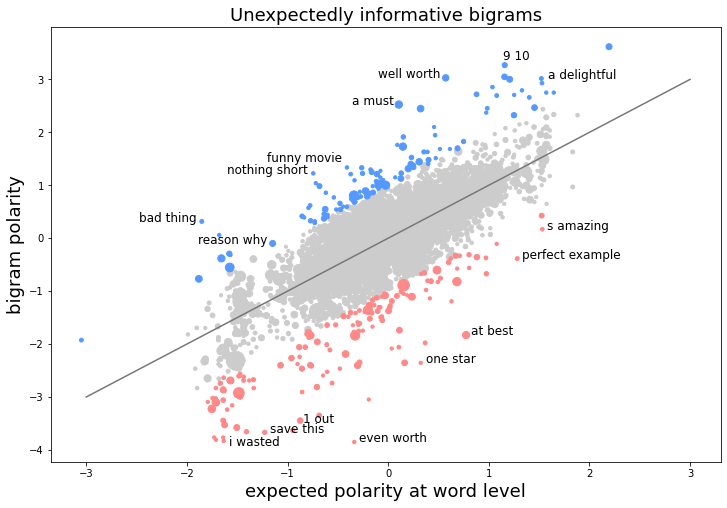

In [128]:
plt.figure(figsize=(12,8)) 
plt.scatter(x = bigram_model[np.abs(bigram_model.residual) < 1].exp_polarity,
            y = bigram_model[np.abs(bigram_model.residual) < 1].actual_polarity,
            s=np.clip(500*bigram_model[np.abs(bigram_model.residual) < 1].freq, None, 1000),
            c='#cccccc')
plt.scatter(x = bigram_model[bigram_model.residual > 1].exp_polarity,
            y = bigram_model[bigram_model.residual > 1].actual_polarity,
            s=500*bigram_model[bigram_model.residual > 1].freq,
            c='#5599ff')
plt.scatter(x = bigram_model[bigram_model.residual < -1].exp_polarity,
            y = bigram_model[bigram_model.residual < -1].actual_polarity,
            s=500*bigram_model[bigram_model.residual < -1].freq,
            c='#ff8888')
for xrbbtt in [(-3,-1.5,0,-0.1,0,0), (-1.5,-1,0,0,0,0), (-1,-0.5,0.05,0.15,0,0), (-0.5, 0,0,0,0,0.1), (0, 0.5,0,0,0,0), (0.5, 1,0,0,0,0), (1, 1.5,0,0,0.3,0.1), (1.5,3,0,0,0.8,0)]:
    sel = bigram_model[(bigram_model.exp_polarity > xrbbtt[0]) & (bigram_model.exp_polarity <= xrbbtt[1])]
    bot = sel.sort_values('residual').iloc[0]
    top = sel.sort_values('residual', ascending=False).iloc[0]  
    plt.annotate('{} {}'.format(bot.gram[0], bot.gram[1]), xy=(bot.exp_polarity+0.05+xrbbtt[2] , bot.actual_polarity+xrbbtt[3]), fontsize=12)
    plt.annotate('{} {}'.format(top.gram[0], top.gram[1]), xy=(top.exp_polarity-0.05+xrbbtt[4], top.actual_polarity+xrbbtt[5]), ha='right', fontsize=12)

#reference line
plt.plot([-3,3],[-3,3],c='#777777')
plt.xlabel('expected polarity at word level', fontsize=18)
plt.ylabel('bigram polarity', fontsize=18)
plt.title('Unexpectedly informative bigrams', fontsize=18)

In [130]:
# Repeat for trigrams
trigrams_for_model = trigram_freqs_by_label[trigram_freqs_by_label.avg > 0.02]
X  = np.take_along_axis(
    np.array(trigrams_for_model[['word0_lsr', 'word1_lsr', 'word2_lsr']]),
    np.argsort(
    np.abs(np.array(trigrams_for_model[['word0_lsr', 'word1_lsr', 'word2_lsr']])),
    axis=-1),
    1
)
#X = PolynomialFeatures(interaction_only=True).fit_transform(X)
y = trigrams_for_model['gram_lsr']

# trim outliers
for col in range(1,np.shape(X)[1]):
    vals = X[:,col]
    m = np.mean(vals)
    s = np.std(vals)
    X[:,col][((vals - m) / s) > 3] = m+3*s
    X[:,col][((vals - m) / s) < -3] = m-3*s

In [131]:
np.shape(trigrams_for_model)

(5357, 10)

In [132]:
# Coefficients of trigram model
reg = linear_model.LinearRegression()
reg.fit(X,y)
reg.coef_

array([0.18832093, 0.73318074, 1.23768687])

In [133]:
trigram_model = pd.DataFrame(
    {
    'gram':list(trigrams_for_model.index),
    'freq':trigrams_for_model.avg,
    'exp_polarity':reg.predict(X),
    'actual_polarity':y
    }
).reset_index(drop=True)
trigram_model['residual'] = trigram_model['actual_polarity'] - trigram_model['exp_polarity']

Text(0.5, 1.0, 'Unexpectedly informative trigrams')

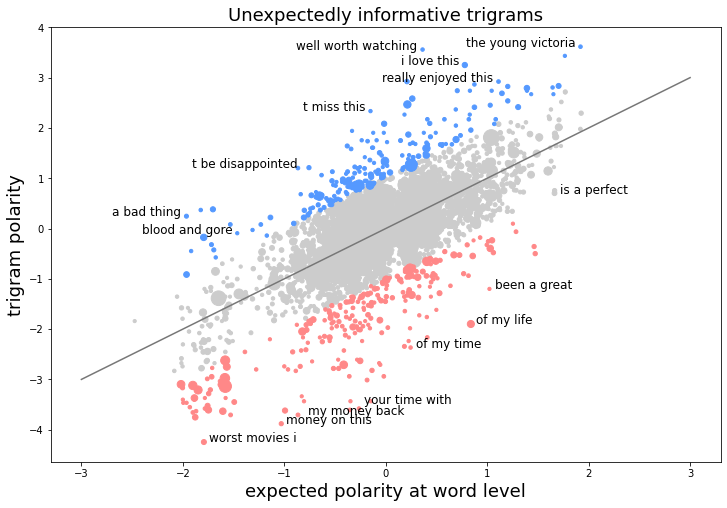

In [140]:
plt.figure(figsize=(12,8)) 
plt.scatter(x = trigram_model[np.abs(trigram_model.residual) < 1].exp_polarity,
            y = trigram_model[np.abs(trigram_model.residual) < 1].actual_polarity,
            s=np.clip(500*trigram_model[np.abs(trigram_model.residual) < 1].freq, None, 1000),
            c='#cccccc')
plt.scatter(x = trigram_model[trigram_model.residual > 1].exp_polarity,
            y = trigram_model[trigram_model.residual > 1].actual_polarity,
            s=500*trigram_model[trigram_model.residual > 1].freq,
            c='#5599ff')
plt.scatter(x = trigram_model[trigram_model.residual < -1].exp_polarity,
            y = trigram_model[trigram_model.residual < -1].actual_polarity,
            s=500*trigram_model[trigram_model.residual < -1].freq,
            c='#ff8888')
for xrbbtt in [(-3,-1.5,0,0,0,0), (-1.5,-1,0,0,0,0), (-1,-0.5,0.05,0,0.05,0,0), (-0.5, 0,0,0.1,0,0,0), (0, 0.5,0,0,0,0), (0.5, 1,0,0,0,0), (1, 1.5,0,0,0,0), (1.5,3,0,0,0,0)]:
    sel = trigram_model[(trigram_model.exp_polarity > xrbbtt[0]) & (trigram_model.exp_polarity <= xrbbtt[1])]
    bot = sel.sort_values('residual').iloc[0]
    top = sel.sort_values('residual', ascending=False).iloc[0]  
    plt.annotate('{} {} {}'.format(bot.gram[0], bot.gram[1], bot.gram[2]), xy=(bot.exp_polarity+0.05+xrbbtt[2] , bot.actual_polarity+xrbbtt[3]), fontsize=12)
    plt.annotate('{} {} {}'.format(top.gram[0], top.gram[1], top.gram[2]), xy=(top.exp_polarity-0.05+xrbbtt[4], top.actual_polarity+xrbbtt[5]), ha='right', fontsize=12)

#reference line
plt.plot([-3,3],[-3,3],c='#777777')
plt.xlabel('expected polarity at word level', fontsize=18)
plt.ylabel('trigram polarity', fontsize=18)
plt.title('Unexpectedly informative trigrams', fontsize=18)

In [147]:
#################################################
##### Feature generator helper functions
#################################################

def get_features(texts, filter_stopwords=True, gram_cutoff = 1, n_features = 1500):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    ftr = np.zeros((len(texts), n_features))
    tri = set(trigram_model[(trigram_model.residual < -gram_cutoff) | (trigram_model.residual > gram_cutoff)].gram)
    bi = set(bigram_model[(bigram_model.residual < -gram_cutoff) | (bigram_model.residual > gram_cutoff)].gram)
    n_uni = n_features - len(tri) - len(bi)
    if n_uni < 0:
        raise ValueError('not enough features to include all the bigrams and trigrams')
    if filter_stopwords:
        uni = set(word_freqs_by_label[
            ~(word_freqs_by_label.index).isin(stopwords)
        ].sort_values('scr', ascending=False).index[:n_uni])
    else:
        uni = set(word_freqs_by_label.sort_values('scr', ascending=False).index[:n_uni])
    ftr_ix = {
        ftr:i for i, ftr in
        enumerate(sorted(list(tri))+sorted(list(bi))+sorted(list(uni)))
    }
    ix_ftr = {
        i:ftr for i, ftr in
        enumerate(sorted(list(tri))+sorted(list(bi))+sorted(list(uni)))
    }
    for text_i, t in enumerate(texts):

        w = [w.lower() for w in t]
        
        row = np.zeros(len(ftr_ix))
        
        # count all the unigrams
        for u in w:
            if u in uni:
                row[ftr_ix[u]] += 1
    
        # count all the bigrams, removing unigrams
        for b in nltk.ngrams(w,2):
            if b in bi:
                row[ftr_ix[b]] += 1
        
        for t in nltk.ngrams(w,3):
            if t in tri:
                row[ftr_ix[t]]+=1
                
        ftr[text_i, :] = row 
    return ftr, ftr_ix, ix_ftr

def get_dataset(texts_pos, texts_neg, filter_stopwords=True, gram_cutoff=1, n_features=1500):
    ftr_pos, ftr_ix, ix_ftr = get_features(texts_pos, filter_stopwords, gram_cutoff, n_features)
    ftr_neg, _, _ = get_features(texts_neg, filter_stopwords, gram_cutoff, n_features)
    X = np.vstack((ftr_pos, ftr_neg))
    y = np.hstack((np.ones(len(texts_pos)), np.zeros(len(texts_neg))))
    return (X, y)

def get_ftr_ix(texts_pos, texts_neg, filter_stopwords=True, gram_cutoff=1, n_features=1500):
    ftr_pos, ftr_ix, ix_ftr = get_features(texts_pos, filter_stopwords, gram_cutoff, n_features)
    return (ftr_ix, ix_ftr)

# A wrapper for grid search over the feature types
def search_feature_types(train_fn, pred_fn, filter_stopwords, gram_cutoff, n_features):
    best_acc = 0
    best_model = None
    res = []
    for fs in filter_stopwords:
        for gc in gram_cutoff:
            for nf in n_features:
                try:
                    X, y = get_dataset(train_pos, train_neg, fs, gc, nf)
                    ftr_ix, ix_ftr = get_ftr_ix(train_pos, train_neg, fs, gc, nf)
                    val_X, val_y = get_dataset(val_pos, val_neg, fs, gc, nf)
                    model = train_fn(X, y, ftr_ix=ftr_ix, ix_ftr=ix_ftr)
                    val_scores = pred_fn(model, val_X)
                    acc = np.mean(np.abs(val_scores - val_y) < 0.5)
                    res.append({
                        'filter_stopwords':fs,
                        'gram_cutoff':gc,
                        'n_features':nf,
                        'acc':acc
                    })
                    #print(res[-1])
                    if acc > best_acc:
                        best_acc = acc
                        best_model = model
                except ValueError:
                    pass
                    #print('cannot train for {} {} {}'.format(fs,gc,nf))
    return pd.DataFrame(res), best_model                

In [148]:
#############
## LR Model #
#############

def train_lr(X, y, **kwargs):
    reg = linear_model.LogisticRegression(max_iter=1000)
    reg.fit(X,y)
    return reg

def score_lr(model, ftr):
    return model.predict(ftr)
    
def pred_lr(model, ftr):
    return score_lr(model,ftr)

In [149]:
res, mod = search_feature_types(train_lr, pred_lr, filter_stopwords=[True,False], gram_cutoff=[.5,.75,1,1.25,9999], n_features=[1000,2000,3000])

c:\users\lucas\documents\euler\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\lucas\documents\euler\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [175]:
#res = res.sort_values('acc', ascending=False)
res.columns = ['filter stopwords', 'gram min polarity', 'n features', 'val acc']
res.loc[res['gram min polarity'] == 9999, 'gram min polarity'] = 'No ngrams'
res

,filter stopwords,gram min polarity,n features,val acc
15,False,1.0,3000,0.881067
4,True,1.0,3000,0.880533
14,False,1.0,2000,0.878533
1,True,0.75,3000,0.878400
3,True,1.0,2000,0.878267
6,True,1.25,2000,0.878267
17,False,1.25,2000,0.877467
18,False,1.25,3000,0.876667
12,False,0.75,3000,0.876400
7,True,1.25,3000,0.876133


In [176]:
# Try with Keras
random.seed(340239432)
train_X, train_y = get_dataset(train_pos, train_neg, 'False', 1, 3000)
val_X, val_y = get_dataset(val_pos, val_neg, 'False', 1, 3000)
test_X, test_y = get_dataset(test_pos, test_neg, 'False', 1, 3000)
inputs = keras.Input(shape=(np.shape(train_X)[1],))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)
model = tf.keras.Model(inputs, predictions)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

batch_size=128
epochs=200

train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_X, val_y)).batch(batch_size)

model_file = 'movie_reviews_sentiment_model.h5'
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', save_best_only=True, save_weights_only=False)

# Fit the model using the train and test datasets.
history = model.fit(train_dataset, validation_data=val_dataset,
          batch_size=batch_size, epochs=epochs,
          shuffle=True,
          callbacks=[early_stopping, model_checkpoint])

model = tf.keras.models.load_model(model_file)

Epoch 1/200
137/137 [==============================] - 1s 6ms/step - loss: 0.6226 - accuracy: 0.8515 - val_loss: 2.9963 - val_accuracy: 0.5000
Epoch 2/200
137/137 [==============================] - 1s 4ms/step - loss: 2.0452 - accuracy: 0.1765 - val_loss: 3.2631 - val_accuracy: 0.5000
Epoch 3/200
137/137 [==============================] - 1s 4ms/step - loss: 1.9083 - accuracy: 0.5341 - val_loss: 3.4410 - val_accuracy: 0.5000
Epoch 4/200
137/137 [==============================] - 1s 4ms/step - loss: 2.1473 - accuracy: 0.4941 - val_loss: 2.6372 - val_accuracy: 0.5000
Epoch 5/200
137/137 [==============================] - 1s 4ms/step - loss: 1.4848 - accuracy: 0.5840 - val_loss: 1.6271 - val_accuracy: 0.5019
Epoch 6/200
137/137 [==============================] - 1s 4ms/step - loss: 0.9132 - accuracy: 0.6525 - val_loss: 3.2791 - val_accuracy: 0.5000
Epoch 7/200
137/137 [==============================] - 1s 4ms/step - loss: 1.4287 - accuracy: 0.6352 - val_loss: 1.2943 - val_accuracy: 0.5443

In [178]:
#############
##### Eval ##
#############
train_X, train_y = get_dataset(train_pos, train_neg, 'False', 1, 3000)
val_X, val_y = get_dataset(val_pos, val_neg, 'False', 1, 3000)
test_X, test_y = get_dataset(test_pos, test_neg, 'False', 1, 3000)
trainval_X = np.vstack((train_X, val_X))
trainval_y = np.hstack((train_y, val_y))
ypred_lr = pred_lr(train_lr(trainval_X, trainval_y), test_X)
print('LR Accuracy on Test:')
print(np.mean(np.abs(ypred_lr - test_y) < 0.5))
ypred_nn = model.predict(test_X).reshape(25000,)
print('NN Accuracy on Test:')
print(np.mean(np.abs(ypred_nn - test_y) < 0.5))

LR Accuracy on Test:
0.87988
NN Accuracy on Test:
0.87848


In [214]:
#############################################
### Inspect Reviews With Wrong Predictions ##
#############################################
ftr_ix, ix_ftr = get_ftr_ix(val_pos, val_neg, 'False', 1, 3000)
n = -3
pos = True
wrong = np.where(np.abs(ypred_lr - test_y) > 0.5)[0]
if pos:
    i = wrong[n]
else:
    i = wrong[-n]
#[ix_ftr[ix] for ix in np.where(test_X[i])[0]]

['actor',
 'almost',
 'boredom',
 'capote',
 'characters',
 'disbelief',
 'everything',
 'fans',
 'felt',
 'film',
 'filmmakers',
 'five',
 'genius',
 'go',
 'great',
 'hoffman',
 'jack',
 'like',
 'looks',
 'man',
 'many',
 'movie',
 'much',
 'need',
 'never',
 'often',
 'others',
 'people',
 'performance',
 'playing',
 'said',
 'scenery',
 'show',
 'shows',
 'sides',
 'sometimes',
 'started',
 'sure',
 'think',
 'times',
 'us',
 'walking',
 'went',
 'wonder',
 'yes']